**Instructor Note:** The code in this notebook is in the file `MNIST_CNN.ipynb` in the student downloads

# 16.6 Convolutional Neural Networks for Vision; Multi-Classification with the MNIST Dataset 
* **`MNIST` database of handwritten digits**
    * “The MNIST Database.” MNIST Handwritten Digit Database, Yann LeCun, Corinna Cortes and Chris Burges. http://yann.lecun.com/exdb/mnist/.
* Create a [**convolutional neural network**](https://en.wikipedia.org/wiki/Convolutional_neural_network) (also called a **convnet** or **CNN**)
* Common in **computer-vision applications**
    * Recognizing handwritten digits and characters
    * Recognizing objects in images and video
    * Self-driving cars
* **Non-vision applications**
    * natural-language processing 
    * recommender systems
    * much more

# 16.6 Convolutional Neural Networks for Vision; Multi-Classification with the MNIST Dataset (cont.)
* **60,000** labeled digit image samples for **training**, **10,000** for testing
* **28-by-28 pixel images** (**784 features**), represented as **NumPy arrays**
* **Grayscale pixel intensity** (shade) values **0-255** 
* **Convnet** will perform [**probabilistic classification**](https://en.wikipedia.org/wiki/Probabilistic_classification)
	* Model will output **10 probabilities** indicating likelihood a digit is **0-9**
	* **Highest probability** is the **predicted value**

### Reproducibility in Keras and Deep Learning
* **Reproducibility is difficult** because the libraries **heavily parallelize floating-point calculations** 
* Each time calculations execute, they may execute in a **different order**
* Can produce **different results** in each execution
* See the [**Keras FAQ on reproducibility**](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

### Building a Keras Neural Network 
* **Network** (also called a **model**)
    * Sequence of layers containing the neurons used to learn from the samples
    * Each layer’s neurons receive inputs, process them (via an **activation function**) and produce outputs
    * The more layers you **stack**, the **deeper** the network is, hence the term **deep learning**
* **Loss function**
    * Produces a measure of **how well the network predicts target values** 
    * **Lower loss values** indicate **better predictions**
* **Optimizer**
    * Attempts to **minimize the values produced by the loss function** to **tune the network** to make better predictions 

### Launch JupyterLab
* Activate your `tf_env` Anaconda environment
* Launch JupyterLab from the `ch15` examples folder

## 16.6.1 Loading the MNIST Dataset

In [1]:
from tensorflow.keras.datasets import mnist

* **`load_data` function** loads **training** and **testing sets**

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## 16.6.2 Data Exploration
* Check dimensions of the **training set images (`X_train`)**, **training set labels (`y_train`)**, **testing set images (`X_test`)** and **testing set labels (`y_test`)**:

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
y_test.shape

(10000,)

### Visualizing Digits
* Display 24 MNIST training set images 

In [7]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns

In [10]:
# sns.set(font_scale=2)

### Visualizing Digits
* Run cell several times to view different digits and see **why handwritten digit recognition is a challenge**

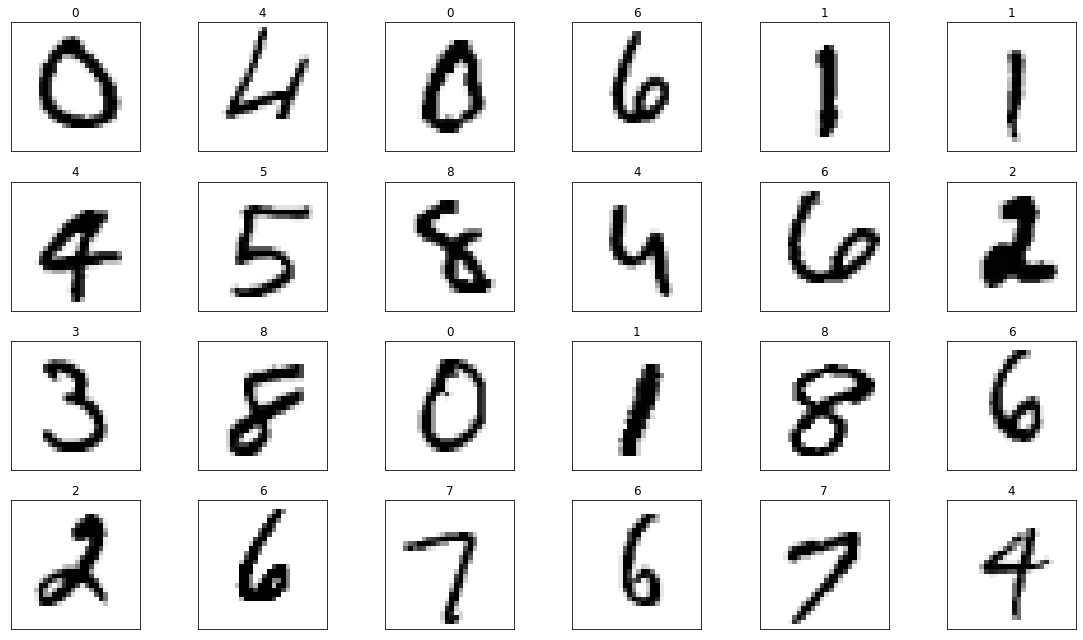

In [11]:
import numpy as np
index = np.random.choice(np.arange(len(X_train)), 24, replace=False)  # 24 indices
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9))

for item in zip(axes.ravel(), X_train[index], y_train[index]):
    axes, image, target = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])  # remove x-axis tick marks
    axes.set_yticks([])  # remove y-axis tick marks
    axes.set_title(target)

plt.tight_layout()

## 16.6.3 Data Preparation
* **Scikit-learn’s bundled datasets** were **preprocessed** into the **shapes its models required**
* MNIST dataset **requires some preparation** for use in a Keras convnet

### Reshaping the Image Data 
* **Keras convnets** require **NumPy array inputs** 
* Each **sample** must have the **shape**
> `(`**width**`,` **height**`,` **channels**`)`
* Each pixel has **one channel** (grayscale shade 0-255), so sample shapes will be 
> **`(28, 28, 1)`**
* As the **neural network learns** from the images, it **creates many more channels**
    * These channels will **represent more complex features**, like **edges**, **curves** and **lines**
    * Enable network to **recognize digits** based on these features and how they’re **combined**

### Reshaping the Image Data (cont.)
* NumPy array method `reshape` receives a tuple representing the new shape

In [12]:
X_train = X_train.reshape((60000, 28, 28, 1)) 

In [13]:
X_train.shape

(60000, 28, 28, 1)

In [14]:
X_test = X_test.reshape((10000, 28, 28, 1))

In [15]:
X_test.shape

(10000, 28, 28, 1)

### Normalizing the Image Data 
* **Numeric feature values** may vary widely
* Deep learning networks **perform better** on data that's **normalized** into
    * the range **0.0-1.0**, or 
    * a range for which the data’s **mean is 0.0** and its **standard deviation is 1.0**
        * S. Ioffe and Szegedy, C., “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.” https://arxiv.org/abs/1502.03167
* Divide **each pixel** value by **255** to normalize into the range **0.0-1.0**:

In [16]:
X_train = X_train.astype('float32') / 255

In [17]:
X_test = X_test.astype('float32') / 255

### One-Hot Encoding: Convert Labels to Categorical Data 
* **Predictions** for each digit will be an **array of 10 probabilities** 
* To **evaluate model accuracy**, Keras **compares predictions to dataset's labels**
    * Both must have the **same shape**
    * MNIST labels are **individual integers 0-9**
* Must **transform labels** into **categorical data arrays** matching the **prediction format**
* Use [**one-hot encoding**](https://en.wikipedia.org/wiki/One-hot) to convert labels from integers into 10-element **arrays of 1.0s and 0.0s** 
    * **only one element is 1.0** and the **rest are 0.0s**
* Categorical representation of a **7**
> <pre>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, <strong>1.0</strong>, 0.0, 0.0]</pre>
* **`tensorflow.keras.utils`** function **`to_categorical`** performs **one-hot encoding**

### One-Hot Encoding: Convert Labels to Categorical Data (cont.)
* Transform **`y_train`** and **`y_test`** into **two-dimensional arrays of categorical data**

In [18]:
from tensorflow.keras.utils import to_categorical

In [19]:
y_train = to_categorical(y_train)

In [20]:
y_train.shape

(60000, 10)

In [21]:
y_train[0]  # one sample’s categorical data

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [22]:
y_test = to_categorical(y_test)

In [23]:
y_test.shape

(10000, 10)

## 16.6.4 Creating the Neural Network
* Configure a **convolutional neural network**
* **`Sequential` model** stacks layers to **execute sequentially**
    * **output** of one layer becomes **input** to the next
    * **Feed-forward network**
    * Later, you’ll see that not all layers feed output to the next layer

In [24]:
from tensorflow.keras.models import Sequential 

In [25]:
cnn = Sequential() 

### Adding Layers to the Network
* A typical **convnet** consists of 
	* **input layer** that receives **training samples**
	* **hidden layers** that **learn** from training samples
	* **output layer** that **produces predictions**
* Import layer classes for a basic **convnet**

In [26]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D 

### Convolution (1 of 6)
* We'll start with a **convolution layer**
* Uses the **relationships between pixels in close proximity** to learn useful **features** (or patterns) in small areas of each sample
* These **features** become **inputs** to **subsequent layers** 

### Convolution (cont.)
* Examine convolution on a 6-by-6 image
* **3-by-3 shaded square** represents the **kernel**
* **Convolution** performs calculations that **learn** from kernel's **9** features, then **outputs 1 new feature** 
![Convolution diagram in which the 3-by-3 shaded square represents the kernel in its initial position](./ch16images/convolution.png "Convolution diagram in which the 3-by-3 shaded square represents the kernel in its initial position")

### Convolution (cont.)
* [**Kernels typically are 3-by-3**](https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN)
    * We found convnets that used **5-by-5** and **7-by-7** 
    * Kernel-size is a **hyperparameter**
* By looking at **features near one another**, the network begins to **recognize features** 
    * Like **edges**, **straight lines** and **curves**

### Convolution (cont.)
* Next, **convolution layer** moves **kernel one pixel to the right** (the **stride**) 
* **Overlaps** with previous kernel, so **convolution layer can learn** from all **features that touch one another**
![Convolution diagram in which the 3-by-3 shaded square is moved one pixel to the right, overlapping with  of the three columns in the previous position](./ch16images/convolution2.png "Convolution diagram in which the 3-by-3 shaded square is moved one pixel to the right, overlapping with  of the three columns in the previous position")

### Convolution (cont.)
* **Complete pass** left-to-right and top-to-bottom is called a **filter**
* For a **3-by-3 kernel**, the filter dimensions will be **two less than the input dimensions**
    * For each 28-by-28 MNIST image, the filter will be 26-by-26 
* **Number of filters** in the **convolutional layer** is commonly **32** or **64** for small images
* Each filter produces different results
* **Higher-resolution images** have **more features**, so they **require more filters**
* [**Keras team’s pretrained convnets**](https://github.com/keras-team/keras-applications/tree/master/keras_applications) use 64, 128 or even 256 filters in their **first convolutional layers**

### Convolution (cont.)
* **Set of filters** produced by a **convolution layer** is called a **feature map**
* Subsequent **convolution layers** combine features from previous feature maps to **recognize larger features** and so on
	* In **facial recognition**, **early layers** might recognize **lines**, **edges** and **curves**, and **subsequent layers** might **combine** those into **features** like **eyes**, **eyebrows**, **noses**, **ears** and **mouths**
* After **learning a feature**, a network can **recognize that feature anywhere** in the **image**
    * One reason **convnets** are popular for **object recognition** in images

### Adding a Convolution Layer
* **`Conv2D`** implements the convolution layer

In [27]:
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
               input_shape=(28, 28, 1)))

Instructions for updating:
Colocations handled automatically by placer.


* **`filters=64`**—The number of **filters** in the resulting **feature map**.
* **`kernel_size=(3, 3)`**—The **size of the kernel** used in each **filter**
* **`activation='relu'`**—**Rectified Linear Unit activation function** is used to produce this layer’s output
    * **Most widely used activation function** (Chollet, François. _Deep Learning with Python_. p. 72. Shelter Island, NY: Manning Publications, 2018)
    * [**Good for performance** because it’s **easy to calculate**](https://towardsdatascience.com/exploring-activation-functions-for-neural-networks-73498da59b02) 
    * [Commonly recommended for **convolutional layers**](https://www.quora.com/How-should-I-choose-a-proper-activation-function-for-the-neural-network) 

### Adding a Convolution Layer (cont.)
* **First layer** in the model, so we specify the shape of each sample with `input_shape=(28, 28,1)` 
	* Creates an **input layer** to **load the samples** and pass them into the **`Conv2D` layer**, which is actually the **first hidden layer**
* Each subsequent layer **infers `input_shape`** from previous layer’s **output shape**
    * Makes it easy to **stack** layers

### Dimensionality of the First Convolution Layer’s Output
* Input samples are 28-by-28-by-1—that is, **784 features each**
* Specified **64 filters** and a **3-by-3 kernel** for the layer, so the **feature map size is 26-by-26-by-64** for a total of **43,264 features** 
	* **Significant increase in dimensionality** 
    * **Enormous** compared to numbers of features processed in our Machine Learning examples
* As each layer adds features, feature map **dimensionality** grows significantly
    * This is one of reason **deep learning** often requires **tremendous processing power**

### Overfitting 
* Can occur when a **model is too complex** compared to what it is modeling
* **Most extreme case**: Model **memorizes** its training data's features
* **Overfitting** tends to occur in **deep learning** as the **dimensionality** becomes **too large** [\[1\]](https://cs231n.github.io/convolutional-networks/),[\[2\]](https://medium.com/@cxu24/why-dimensionality-reduction-is-important-dd60b5611543),[\[3\]](https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a)
* **Higher dimensionality** also increases (and sometimes explodes) **computation time**
* For deep learning on **CPUs**, training could become **intolerably slow**
* There are various techniques to **prevent overfitting** [\[1\]](https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d), [\[2\]](https://www.kdnuggets.com/2015/04/preventing-overfitting-neural-networks.html) &mdash; we'll use **pooling**

### Adding a Pooling Layer 
* To **reduce overfitting** and **computation time**, a **convolution layer** is often followed by one or more layers that **reduce dimensionality** of **convolution layer’s output**
* **Pooling compresses** (or **down-samples**) the results by **discarding features**
    * Helps make the model **more general**
* **Most common pooling technique** is called **max pooling**
	* Examines a 2-by-2 square of features and keeps only the maximum feature.

### Adding a Pooling Layer (cont.)
* 2-by-2 blue square in position 1 represents the initial pool of features to examine:

![Max pooling diagram showing the 6-by-6 set of numeric values we wish to compress with the 2-by-2 blue square in position 1 representing the initial pool of features to examine, and the 3-by-3 square representing the results of max pooling](./ch16images/pooling.png "Max pooling diagram showing the 6-by-6 set of numeric values we wish to compress with the 2-by-2 blue square in position 1 representing the initial pool of features to examine, and the 3-by-3 square representing the results of max pooling")z

### Adding a Pooling Layer (cont.)
* Outputs **maximum feature** from each pool
* **Pools do not overlap** 
* **Stride** for a 2-by-2 pool is **2**
* Every group of four features is reduced to one, so 2-by-2 pooling **compresses** number of features by **75%**
* Reduces previous layer’s output from **26-by-26-by-64** to **13-by-13-by-64**

In [28]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

### Adding Another Convolutional Layer and Pooling Layer
* **Convnets** often have **many convolution and pooling layers**. 
* [Keras team’s convnets](https://github.com/keras-team/keras-applications/tree/master/keras_applications) tend to **double** the number of **filters** in subsequent **convolutional layers** to enable the models to learn more relationships between the features

In [29]:
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

In [30]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

* **Input** to the **second convolution layer** is the 13-by-13-by-64 **output of the first pooling layer**
* **Output** of this **Conv2D layer** will be **11-by-11-by-128**
* For **odd dimensions** like 11-by-11, **Keras pooling layers round down** by default (in this case to 10-by-10), so this pooling layer’s **output** will be **5-by-5-by-128**

### Flattening the Results
* Model's **final output** will be a **one-dimensional** array of 10 probabilities that classify the digits
* To prepare for **one-dimensional final predictions**, need to **flatten** the previous layer’s output to **one dimension**
* **`Flatten`** layer's output will be **1-by-3200** (5 &#215; 5 &#215; 128)

In [31]:
cnn.add(Flatten())

### Adding a Dense Layer to Reduce the Number of Features
* Layers before the **`Flatten`** layer **learned digit features**
* Now must **learn the relationships among those features** to **classify** which digit each image represents
* Accomplished with **fully connected `Dense` layers**
* The following **`Dense` layer** creates **128 neurons (`units`)** that **learn** from the 3200 outputs of the previous layer

In [32]:
cnn.add(Dense(units=128, activation='relu'))

* Many **convnets** contain **at least one `Dense` layer** 
* **Convnets** geared to more complex image datasets with higher-resolution images like [**ImageNet**](http://www.image-net.org)—a dataset of over 14 million images—often have **several `Dense` layers**, commonly with **4096 neurons**
* See the [Keras pretrained ImageNet convnets' code](https://github.com/keras-team/keras-applications/tree/master/keras_applications)

### Adding Another Dense Layer to Produce the Final Output
* Final **`Dense`** layer **classifies** inputs into **neurons** representing the classes **0-9**
* The **`softmax` activation function** converts values of these 10 neurons into **classification probabilities**
* **Neuron** with **highest probability** represents the **prediction** for a given digit image

In [33]:
cnn.add(Dense(units=10, activation='softmax'))

### Printing the Model’s Summary 
* Use model’s **`summary`** method
* Note layers' **output shapes** and **numbers of parameters**
* **Parameters** are the **weights** that the network **learns** during training [\[1\]](https://hackernoon.com/everything-you-need-to-know-about-neural-networks-8988c3ee4491),[\[2\]](https://www.kdnuggets.com/2018/06/deep-learning-best-practices-weight-initialization.html) 
* **Relatively small network**, but needs to **learn nearly 500,000 parameters**! 
	* This is for **tiny images** that are less than 1/4 the size of icons on smartphone home screens
	* Imagine how many features a network would have to learn to process high-resolution 4K video frames or the super-high-resolution images produced by today’s digital cameras 
* In the **`Output Shape`** column, **`None`** means the model does not know in advance how many training samples you’re going to provide

In [34]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               409728    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total para

### Visualizing a Model’s Structure 
* Use the **`plot_model` function** from module `tensorflow.keras.utils`

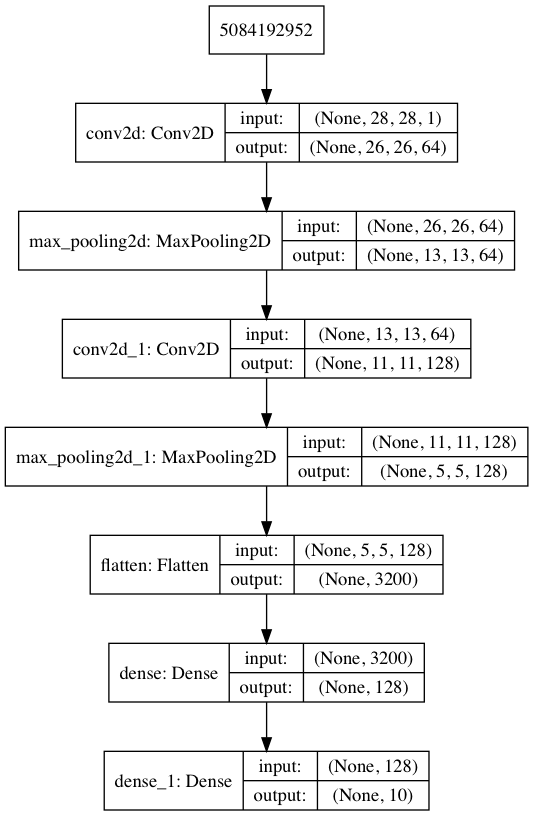

In [35]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(cnn, to_file='convnet.png', show_shapes=True, 
           show_layer_names=True)
Image(filename='convnet.png')  # display resulting image in notebook

### Compiling the Model 
* Complete the model by calling its **`compile` method**

In [36]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### Compiling the Model (cont.)
* **`optimizer='adam'`**—The **optimizer** this model uses to **adjust the weights** throughout the neural network **as it learns**
	* [**Keras optimizers**](https://keras.io/optimizers/)
	* `'adam'` performs well across a wide variety of models [\[1\]](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2),[\[2\]](https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f)

### Compiling the Model (cont.)
* **`loss='categorical_crossentropy'`**—The **loss function** used by the optimizer in **multi-classification networks** (ours predicts 10 classes)
	* **Optimizer** attempts to **minimize the values returned by the loss function** 
	* For **binary classification**, Keras provides **`'binary_crossentropy'`**, and for **regression**, **`'mean_squared_error'`**
	* [Other loss functions](https://keras.io/losses/)

### Compiling the Model (cont.)
* **`metrics=['accuracy']`**—List of **metrics** the network will produce to help you **evaluate the model**
	* **Accuracy** commonly used in **classification models**
	* We’ll use it to check **percentage of correct predictions**
	* [Other metrics](https://keras.io/metrics/)

## 15.6.5 Training and Evaluating the Model 
* **Train a Keras model** by calling its **`fit` method**
```python
cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)
```
* **`epochs=5`**&mdash;train neural networks iteratively over time
    * Each **`epoch`** processes **every training dataset sample** once
    * **Hyperparameter** that may need tuning
* **`batch_size=64`**&mdash;**number of samples to process at a time**
    * Most models specify a **power of 2 from 32 to 512**
* [**`validation_split=0.1`**&mdash;model should reserve the **last** 10% of the training samples for validation](https://keras.io/getting-started/faq/#how-is-the-validation-split-computed) 
	* After each **epoch**, model uses validation samples to **make predictions** and display the **validation loss and accuracy** 
    * Use **tune your layers** and the **`fit` method’s hyperparameters**, or possibly change the **layer composition** of your model
    * Can specify **separate validation data** with **`validation_data` argument** 

## 15.6.5 Training and Evaluating the Model (cont.)
* Model took about 5 minutes to train on our CPU.
* **Lecture note: Play convnet timelapse video here**

In [37]:
cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
54000/54000 [==============================] - 62s 1ms/sample - loss: 0.1424 - acc: 0.9569 - val_loss: 0.0465 - val_acc: 0.9868
Epoch 2/5
54000/54000 [==============================] - 55s 1ms/sample - loss: 0.0441 - acc: 0.9861 - val_loss: 0.0409 - val_acc: 0.9872
Epoch 3/5
54000/54000 [==============================] - 56s 1ms/sample - loss: 0.0299 - acc: 0.9905 - val_loss: 0.0342 - val_acc: 0.9908
Epoch 4/5
54000/54000 [==============================] - 62s 1ms/sample - loss: 0.0213 - acc: 0.9934 - val_loss: 0.0307 - val_acc: 0.9918
Epoch 5/5
54000/54000 [==============================] - 57s 1ms/sample - loss: 0.0154 - acc: 0.9948 - val_loss: 0.0402 - val_acc: 0.9903


## 15.6.5 Training and Evaluating the Model (cont.)
* As training proceeds, **`fit`** shows the **progress** of each **epoch**, **how long** the epoch took to execute, and the **evaluation metrics** for that epoch
* Impressive **training accuracy (`acc`**) and **validation accurracy (`acc`)**, given that **we have not yet tried to tune the hyperparameters** or **tweak the number and types of the layers**

### Evaluating the Model on Unseen Data with Model’s **`evaluate` Method**

In [38]:
loss, accuracy = cnn.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 276us/sample - loss: 0.0341 - acc: 0.9905


In [39]:
loss

0.03405798594321095

In [40]:
accuracy

0.9905

* Without tuning, our **convnet model** is **99+% accurate** for **unseen data samples**
    * Can find models online that predict MNIST with even **higher accuracy**
    * **Experiment** with different numbers of layers, types of layers and layer parameters and observe how those changes affect your results

### Making Predictions with the Model’s **`predict` Method** 

In [41]:
predictions = cnn.predict(X_test)

* The first digit should be a 7 (shown as `1.` at index 7)

In [42]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

* Check the **probabilities** returned by **`predict`** for **first test sample**

In [43]:
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

0: 0.0000071489%
1: 0.0000003010%
2: 0.0129567663%
3: 0.0024080835%
4: 0.0000000012%
5: 0.0000010816%
6: 0.0000000000%
7: 99.9845504761%
8: 0.0000076410%
9: 0.0000659018%


* Our model believes this digit is a 7 with **nearly** 100% certainty
* Not all predictions have this level of certainty

### Locating the Incorrect Predictions 
* View some **incorrectly predicted images** to get a sense of digits **our model has trouble with**
	* If the model always mispredicts 8s, perhaps we need more 8s in our training data
* To determine whether a prediction was correct, compare the index of the largest probability in `predictions[0]` to the index of the element containing **`1.0` in `y_test[0]`**
	* If **indices** are the same, **prediction was correct**

### Locating the Incorrect Predictions (cont.)
* **Reshape the samples** from the shape `(28, 28, 1)` that Keras required for learning back to `(28, 28)`, which **Matplotlib requires to display the images**

In [44]:
images = X_test.reshape((10000, 28, 28))

In [45]:
incorrect_predictions = []

* In the following snippet, **`p`** is the **predicted value array**, and **`e`** is the **expected value array**
* **NumPy’s `argmax` function** determines **index** of an array’s **highest valued element**

In [46]:
for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)

    if predicted != expected:  # prediction was incorrect
        incorrect_predictions.append(
            (i, images[i], predicted, expected))

In [47]:
len(incorrect_predictions)  # number of incorrect predictions

95

### Visualizing Incorrect Predictions
* **Display 24 of the incorrect images** labeled with each image’s index, predicted value (`p`) and expected value (`e`)
* Before reading the **expected values**, look at each digit and write down what digit you think it is
* This is an important part of **getting to know your data**
<!--![24 incorrectly predicted digit images](./ch15images/incorrect24.png "24 incorrectly predicted digit images")-->

 

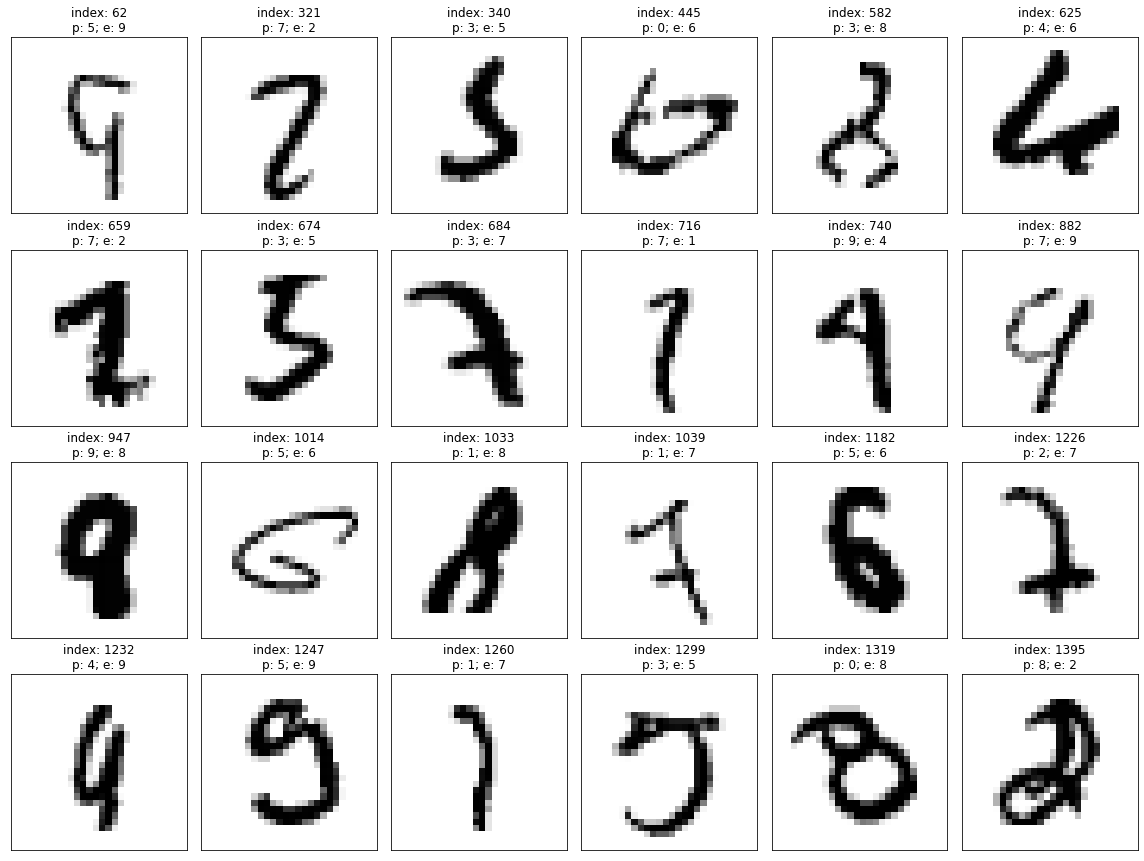

In [48]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])  # remove x-axis tick marks
    axes.set_yticks([])  # remove y-axis tick marks
    axes.set_title(f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

### Displaying the Probabilities for Several Incorrect Predictions
* The following function displays the probabilities for the specified prediction array:

In [49]:
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')

* **Instructor Note:** Change the index values in the next three cells to specific indicies listed in the image output above

In [54]:
display_probabilities(predictions[340])

0: 0.0000003121%
1: 0.0004003516%
2: 0.0000000012%
3: 95.1051056385%
4: 0.0000008515%
5: 4.8939082772%
6: 0.0004849016%
7: 0.0000000009%
8: 0.0000968651%
9: 0.0000029706%


In [55]:
display_probabilities(predictions[740])

0: 0.0000017639%
1: 0.0015670636%
2: 0.0327224814%
3: 0.0069872098%
4: 46.4839726686%
5: 0.0002940589%
6: 0.0000000019%
7: 0.0580247492%
8: 0.0007603798%
9: 53.4156739712%


In [56]:
display_probabilities(predictions[1260])

0: 0.0086790991%
1: 65.1024103165%
2: 1.0480390862%
3: 0.0924306980%
4: 0.0008484539%
5: 0.0021702135%
6: 0.0000045273%
7: 33.6686372757%
8: 0.0329922128%
9: 0.0437857030%


## 16.6.6 Saving and Loading a Model 
* Can **save state** of a model
* Can **load it later** to 
    * Make more predictions
    * Train more
    * Train for new problems
    * **Transfer learning** to a new model 
    > https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751), [\[2\]](https://medium.com/nanonets/nanonets-how-to-use-deep-learning-when-you-have-limited-data-f68c0b512cab)

## 16.6.6 Saving and Loading a Model (cont.)
* Can store **model architecture** and **state** in a **Hierarchical Data Format (HDF5)** file for later use

In [ ]:
cnn.save('mnist_cnn.h5')

* Load a saved model 

>```python
from tensorflow.keras.models import load_model
cnn = load_model('mnist_cnn.h5')
```

* Can then invoke its methods
    * Could call **`predict`** to make **additional predictions on new data**
    * Could call **`fit`** to **train with additional data**
* [Additional functions that enable you to **save and load various aspects of your models**](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

------
&copy;1992&ndash;2020 by Pearson Education, Inc. All Rights Reserved. This content is based on Chapter 5 of the book [**Intro to Python for Computer Science and Data Science: Learning to Program with AI, Big Data and the Cloud**](https://amzn.to/2VvdnxE).

DISCLAIMER: The authors and publisher of this book have used their 
best efforts in preparing the book. These efforts include the 
development, research, and testing of the theories and programs 
to determine their effectiveness. The authors and publisher make 
no warranty of any kind, expressed or implied, with regard to these 
programs or to the documentation contained in these books. The authors 
and publisher shall not be liable in any event for incidental or 
consequential damages in connection with, or arising out of, the 
furnishing, performance, or use of these programs.                  